# <a id="inicio"></a> Trabalho Final

-----

### **Autor:** Glauco Lauria Marques Filho

-----

# <a id="resumo"></a> Resumo 

#### Este arquivo contém a resolução do trabalho final do curso CEDS-808: Aprendizado de Máquina. Neste trabalho, o autor aplica algumas técnicas e modelos para realizar previsões e regressões acerca de dados de casos de dengue na cidade de Campinas/SP de 1998 a 2014.

* [Início](#inicio)
* [Resumo](#resumo)
* [Sumário](#sumario)
* [Importação de Requisitos](#requisitos)

1. [Origem dos Dados](#origem)
2. [Exploração Inicial](#exploracao)
3. [Tratamento de dados faltantes](#missingdata)
4. [Enriquecimento dos dados](#adddata)
5. [Exploração Avançada](#exploracao2)
6. [Remoção de Features](#remocao)
7. [Remoção de Outliers](#remocao2)
8. [Normalização dos Dados](#normalizacao)
9. [Treinamento de Modelos de Regressão](#regressao)
10. [Treinamento de Modelos de Classificação](#classificacao)

# <a id="requisitos"></a> Importação de Requisitos

In [1]:
import warnings
import seaborn as sns
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Suprimindo warnings de convergência
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# <a id="origem"></a> 1. Origem dos Dados


O dataset utilizado pelo autor pode ser encontrado nesse link do [Kaggle](https://www.kaggle.com/datasets/renangomes/dengue-temperatura-e-chuvas-em-campinassp/data). Basicamente, trata-se do número de casos mensais confirmados de dengue no município de Campinas/SP de 1998 a 2014, e dados de chuvas, temperatura média, mínima e máxima na cidade. O responsável pelo dataset no Kaggle cita que os dados foram retirados dos órgãos SES (Secretaria Estadual de Saúde) e SINAN (Sistema de Informação de Agravos de Notificação). Os dados climáticos foram obtidos de tabelas encontradas em ciiagro.sp.gov.br.




# <a id="exploracao"></a> 2. Exploração Inicial

O conteúdo descrito no Kaggle é o seguinte:

* Mês: O mês no formato AAAA-MM-DD
* Casos confirmados: Total de casos de dengue confirmados no mês
* Chuva: Total em mm, de chuva na cidade no mês
* Temperatura Média/Mínima e Máxima: Temperatura diária Média/Mínima e Máxima

In [2]:
df = pd.read_csv(
    "dengue-dataset.csv",
    dtype={
        "data": str,
        "casos-confirmados": float,
        "chuva": float,
        "temperatura-media": float,
        "temperatura-mininima": float,
        "temperatura-maxima": float,
    },
)
df.describe(include='all')

,data,casos-confirmados,chuva,temperatura-media,temperatura-mininima,temperatura-maxima
count,204,204.000000,196.000000,204.000000,204.000000,204.000000
unique,204,NaN,NaN,NaN,NaN,NaN
top,1998-01-01,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN
mean,NaN,357.539216,116.650000,22.200980,17.679412,25.565196
std,NaN,1741.814759,96.631613,2.399363,3.336316,2.249864
min,NaN,0.000000,0.800000,16.400000,8.200000,19.100000
25%,NaN,6.000000,43.850000,20.100000,15.075000,23.800000
50%,NaN,17.500000,86.650000,22.700000,18.150000,26.200000
75%,NaN,84.500000,177.925000,24.225000,20.400000,27.200000


Pode-se, através do `describe`, ter uma ideia dos dados. O primeiro insight é de que estão faltando 8 dados de chuvas, já que todas as medidas possuem um `count` de 204, e chuva possui apenas 196. Possivelmente, existe um outlier em casos confirmados, pois alcanca a um máximo de mais de vinte mil casos em um mês, bem diferente da sua média de 357. Os tratamentos para esses dados serão vistos em itens futuros.

# <a id="missingdata"></a> 3. Tratamento de dados faltantes

Existem diversas técnicas para lidar com dados faltantes: usar a média, a moda ou remover a observação. Nesse caso, por se tratar de algo muito pontual (8 valores de chuvas), o autor decidiu procurar por fontes alternativas para lidar com esses dados. O autor encontrou um [site](https://www.cpa.unicamp.br/graficos) ligado à Unicamp, que possui o registro de chuvas, e então coletou os valores faltantes.

 | Data | chuva |
   |---|---|
   | 1999-07-01 | 2 |
   | 1999-08-01 | 0 |
   | 2002-06-01 | 0 |
   | 2004-08-01 | 0 |
   | 2007-08-01 | 0 |
   | 2008-07-01 | 191 |
   | 2010-08-01 | 0 |
   | 2012-08-01 | 0 |


In [3]:
df.iat[18, 2] = 2
df.iat[19, 2] = 0
df.iat[53, 2] = 0
df.iat[79, 2] = 0
df.iat[115, 2] = 0
df.iat[126, 2] = 191
df.iat[151, 2] = 0
df.iat[175, 2] = 0

# <a id="adddata"></a> 4. Enriquecimento dos dados

Nos modelos iniciais testados durante a confecção desse trabalho, o R2 obtido na regressão não passava de 0.14, um valor bem baixo. Para tentar melhorar isso, o autor decidiu, de alguma maneira, enriquecer os dados. Foi percebida uma falta de dados que demonstrassem o crescimento da população ao longo dos anos, pois se a população cresce muito e os números de casos de dengue não crescem na mesma proporção, isso indicaria uma melhora no cenário da doença.

Para adicionar esse dado, foram consultados os Censos do IBGE para a cidade de Campinas. Os dados pertinentes são:

 | Ano | Habitantes |
   |---|---|
| 1991-01-01 | 847595|
|2000-01-01 | 969396|
|2010-01-01 | 1080999|
|2022-01-01 | 1139047|

Dados falsos de referência para 1991 e 2022 serão adicionados ao dataframe. Será realizada uma interpolação linear para demonstrar o crescimento da população no período amostrado e, em seguida, os dados falsos iniciais serão removidos. Com isso, será calculada uma nova coluna, "casos para cada 100 mil habitantes" (casos_p_100k), uma medida bem mais confiável do que os casos absolutos.

In [4]:
linha_0 = pd.DataFrame({
    "data": ["1991-01-01"],
    "casos-confirmados": [0],
    "chuva": [0],
    "temperatura-media": [0],
    "temperatura-mininima": [0],
    "temperatura-maxima": [0]}
)
linha_205 = pd.DataFrame({
    "data": ["2022-01-01"],
    "casos-confirmados": [0],
    "chuva": [0],
    "temperatura-media": [0],
    "temperatura-mininima": [0],
    "temperatura-maxima": [0]}
)

df = pd.concat([linha_0, df], ignore_index=True)
df = pd.concat([df, linha_205], ignore_index=True)

populacao = {
    pd.Timestamp("1991-01-01"): 847595,
    pd.Timestamp("2000-01-01"): 969396,
    pd.Timestamp("2010-01-01"): 1080999,
    pd.Timestamp("2022-01-01"): 1139047,
}

df["data"] = pd.to_datetime(df["data"])
df["populacao"] = df["data"].map(populacao)
df["populacao"] = df["populacao"].interpolate(method="linear")
df["populacao"] = df["populacao"].astype(int)

df["casos_p_100k"] = df["casos-confirmados"] / (df["populacao"]/100000)

df.drop(index=[0, 205], inplace=True)

with pd.option_context('display.max_rows', 6, 'display.max_columns', None):
    print(df[["data","casos-confirmados","populacao","casos_p_100k"]])


          data  casos-confirmados  populacao  casos_p_100k
1   1998-01-01              237.0     852467     27.801663
2   1998-02-01              331.0     857339     38.607832
3   1998-03-01              562.0     862211     65.181261
..         ...                ...        ...           ...
202 2014-10-01               40.0    1136144      3.520680
203 2014-11-01               57.0    1137112      5.012699
204 2014-12-01               37.0    1138079      3.251092

[204 rows x 4 columns]


Com isso, foi obtida a evolução teórica da população ao longo dos meses do período de amostragem.

De forma a complementar mais uma vez o dataset, foi decidido trazer informações de investimento em saúde anual do município. Na teoria, um maior investimento em saúde traria uma maior campanha dos órgãos de vigilância sanitária, assim como programas de conscientização da doença. Para trazer esse indicador, foram consultadas LOAs (Lei Orçamentária Anual), Diário Oficial e notícias de jornal. Foi possível reunir alguns orçamentos da saúde municipal, porém faltaram alguns dados: 2005, 2004, 2003, 2001, 1999 e 1998. Esses faltantes também foram calculados com interpolação. Importante lembrar que os dados também foram corrigidos pela inflação utilizando o IPCA. Com os dados de investimento, também calcularemos uma nova coluna, investimento em saúde por habitante (investimento_p_habitante).

Os dados obtidos foram:

 | Ano | Orcamento | Corr. Infla. | Orcamento Final |
   |---|---|---|---|
| 1998 | - | - | 784238273.22 |
| 1999 | - | - | 792559136.61 |
| 2000 | 188000000 | 4.26 | 800880000.00 |
| 2001 | - | - | 809200863.39 |
| 2002 | 218588697 | 3.74 | 817521726.78 |
| 2003 | - | - | 880141045.08 |
| 2004 | - | - | 939141044.39 |
| 2005 | - | - | 1008332363.69 |
| 2006 | 400000000 | 2.67 | 1068000000.00 |
| 2007 | 445000000 | 2.59 | 1152550000.00 |
| 2008 | 518200000 | 2.48 | 1285136000.00 |
| 2009 | 654000000 | 2.34 | 1530360000.00 |
| 2010 | 717517988 | 2.24 | 1607240293.12 |
| 2011 | 807363166 | 2.12 | 1711609911.92 |
| 2012 | 846603134 | 1.99 | 1684740236.66 |
| 2013 | 1000262264 | 1.88 | 1880493056.32 |
| 2014 | 1027369524 | 1.78 | 1828717752.72 |
| 2015 | 1115767005 | 1.67 | 1863330898.35 |



In [5]:
investimento_saude = {
    2015: 1115767005.00 * 1.67,
    2014: 1027369524.00 * 1.78,
    2013: 1000262264.00 * 1.88,
    2012: 846603134.00 * 1.99,
    2011: 807363166.00 * 2.12,
    2010: 717517988.00 * 2.24,
    2009: 654000000.00 * 2.34,
    2008: 518200000.00 * 2.48,
    2007: 445000000.00 * 2.59,
    2006: 400000000.00 * 2.67,
    2002: 218588697.00 * 3.74,
    2000: 188000000.00 * 4.26,
    2005: 1008332363.695,
    2004: 939141044.39,
    2003: 880141045.085,
    2001: 809200863.39,
    1999: 792559136.61,
    1998: 784238273.22,
}

# Transformando a coluna data para mês e ano inteiro
df["mes"] = df["data"].dt.month
df["ano"] = df["data"].dt.year
df["mes"] = df["mes"].astype(int)
df["ano"] = df["ano"].astype(int)
del df["data"]

# Adicionando o investimento em saude anual
df["investimento_saude"] = df["ano"].map(investimento_saude)

df["investimento_p_habitante"] = df["investimento_saude"] / (df["populacao"])

with pd.option_context('display.max_rows', 6, 'display.max_columns', None):
    print(df[["ano", "mes", "investimento_saude", "investimento_p_habitante"]])


      ano  mes  investimento_saude  investimento_p_habitante
1    1998    1        7.842383e+08                919.963205
2    1998    2        7.842383e+08                914.735330
3    1998    3        7.842383e+08                909.566537
..    ...  ...                 ...                       ...
202  2014   10        1.828718e+09               1609.582723
203  2014   11        1.828718e+09               1608.212518
204  2014   12        1.828718e+09               1606.846056

[204 rows x 4 columns]


Depois desses dados adicionados, os modelos foram rodados novamente e o R2 passou de 0.14 para 0.50+, uma melhora bem significativa.

# <a id="exploracao2"></a> 5. Exploração Avançada


Depois das transformações ocorridas no item anterior, o target mudou para (casos_p_100k). Para verificar a distribuição dos valores de casos, foi definido arbitrariamente 3 faixas de risco:

* 0 até 50 casos por 100 mil habitantes foi definido como classe de Baixo Risco.
* 51 até 100 casos por 100 mil habitantes será de Médio Risco.
* Mais que 100 casos por 100 mil habitantes será um caso de Alto Risco.

Em itens futuros, será trabalhada a previsão da classe de risco, e essas definições serão reutilizadas. Por hora, será feita apenas uma regressão, e essas faixas serão úteis para visualizar o comportamento dos dados.

In [6]:
baixo_limite = 50
medio_limite = 100

Um gráfico de densidade dos casos por 100mil habitantes poderá ajudar a visualizar o comportamento dos dados.

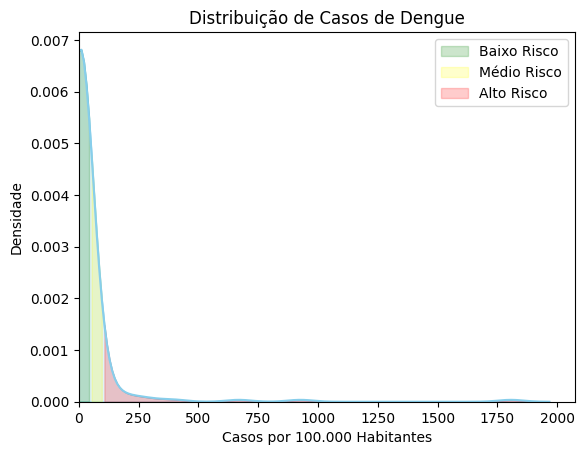

In [7]:
sns.kdeplot(data=df, x="casos_p_100k", fill=True, color="skyblue")

density = sns.kdeplot(data=df['casos_p_100k'], color="skyblue").get_lines()[0].get_data()

plt.fill_between(density[0], density[1], color='green', alpha=0.2, where=(density[0] <= baixo_limite), label='Baixo Risco')
plt.fill_between(density[0], density[1], color='yellow', alpha=0.2, where=((density[0] > baixo_limite) & (density[0] <= medio_limite)), label='Médio Risco')
plt.fill_between(density[0], density[1], color='red', alpha=0.2, where=(density[0] > medio_limite), label='Alto Risco')

plt.legend()
plt.xlim(0)
plt.xlabel('Casos por 100.000 Habitantes')
plt.ylabel('Densidade')
plt.title('Distribuição de Casos de Dengue')

plt.show()


Mais uma vez, pode-se verificar a possível presença de outliers. A maior parte dos dados fica entre 0 e 500 casos, porém temos valores extremamente altos. Em itens futuros, serão feitos alguns tratamentos sobre esses outliers.

Para visualizar o comportamento de todas as features, será feito um Violin plot.

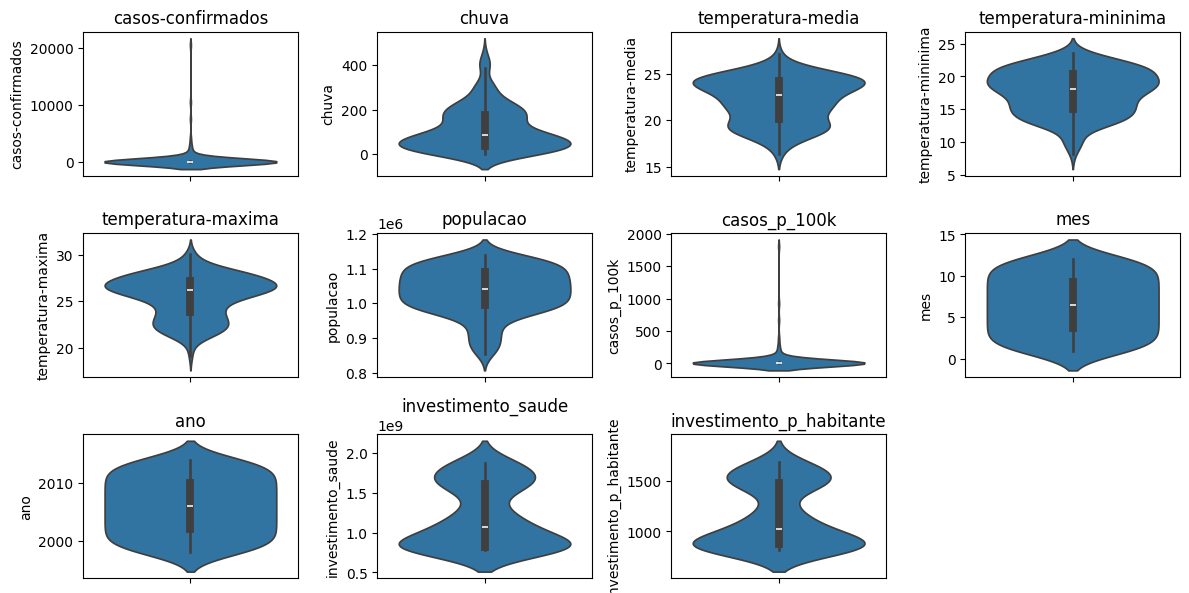

In [8]:
plt.figure(figsize=(12, 8))
for i, column in enumerate(df.columns, 1):
    plt.subplot(4, 4, i)
    sns.violinplot(y=df[column])
    plt.title(column)

plt.tight_layout()
plt.show()

Pelo gráfico, tudo indica que apenas as targets possuem outliers. Será plotada agora uma matriz de correlação para verificar a correlação entre as medidas.

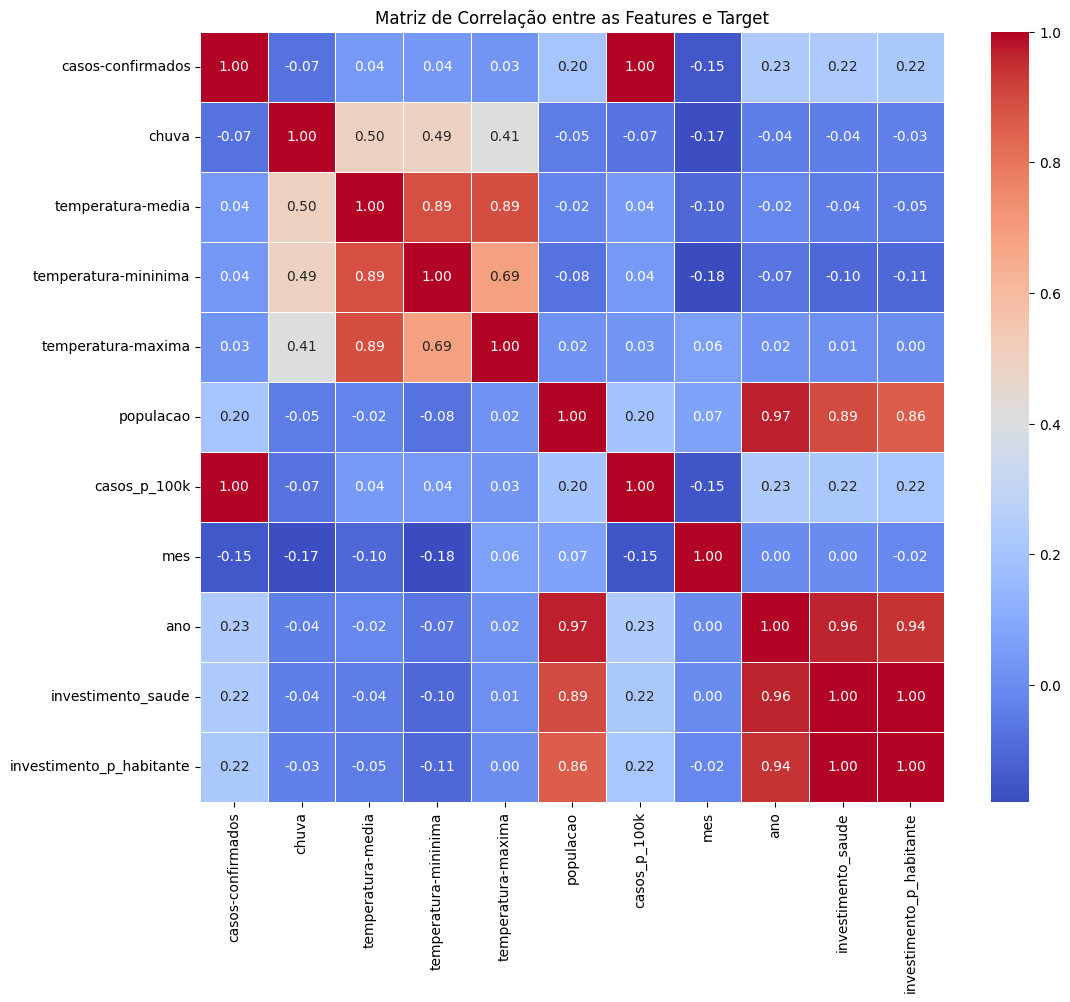

In [9]:
correlation_matrix = df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Matriz de Correlação entre as Features e Target')
plt.show()

De acordo com o gráfico, existe uma alta correlação entre Ano, Investimento, Investimento por habitante e População. Isso era esperado, pois algumas dessas medidas foram derivadas de outras. Isso será resolvido nos próximos itens. Assim como existe alta correlação entre Temperatura Máxima e Mínima com a Temperatura Média.

# <a id="remocao"></a> 6. Remoção de Features

Para lidar com problemas de alta correlação e remoção de dados não pertinentes, algumas features serão removidas:

* Investimento em Saúde será removido, pois será considerado no modelo apenas o Investimento por Habitante.
* Casos Confirmados serão removidos, pois será considerado no modelo apenas Caso por 100 mil Habitantes.
* População será removida, pois existe uma alta correlação dela com Investimento por Habitante e Casos por Habitante.
* Ano também será removido, pois existe uma alta correlação dele com Investimento por Habitante e Casos por Habitante.
* Temperatura Máxima será removida, pois existe uma alta correlação dela com Temperatura Média.
* Temperatura Mínima será removida, pois existe uma alta correlação dela com Temperatura Média.

In [10]:
df_original = df.copy()
del df["investimento_saude"]
del df["populacao"]
del df["casos-confirmados"]
del df["ano"]
del df["temperatura-mininima"]
del df["temperatura-maxima"]

Após as remoções, o gráfico de correlação fica da seguinte maneira:

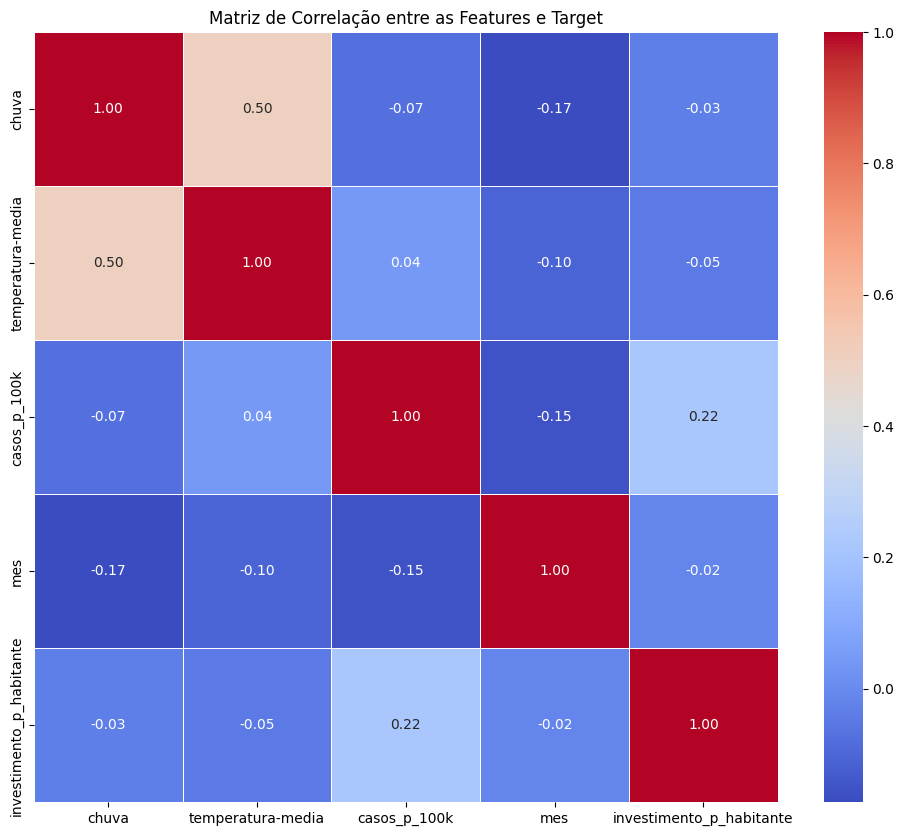

In [11]:
correlation_matrix = df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Matriz de Correlação entre as Features e Target')
plt.show()

# <a id="remocao2"></a> 7. Remoção de Outliers

Para verificar se as amostras com um altíssimo número de casos são de fato outliers causados por algum problema na coleta, vamos listar os maiores casos e então procurar um histórico na internet para verificar se esse cenário de fato ocorreu.

In [12]:
df_original = df_original.sort_values(by="casos-confirmados",ascending=False)
with pd.option_context('display.max_rows', 14, 'display.max_columns', None):
    print(df_original[["ano","mes","casos-confirmados","casos_p_100k"]])

      ano  mes  casos-confirmados  casos_p_100k
196  2014    4            20428.0   1807.245437
197  2014    5            10484.0    926.715737
195  2014    3             7555.0    668.955844
112  2007    4             4207.0    400.549172
111  2007    3             3213.0    306.181376
..    ...  ...                ...           ...
68   2003    8                0.0      0.000000
79   2004    7                0.0      0.000000
22   1999   10                0.0      0.000000
23   1999   11                0.0      0.000000
78   2004    6                0.0      0.000000

[204 rows x 4 columns]


Ao consultar [histórico](https://saude.campinas.sp.gov.br/noticias/2014/not_07_14/not_04_07_14a.htm) da Prefeitura de Campinas, fato, foram registrados números altíssimos de casos no ano de 2014. No entanto, ao realizar análises considerando esses outliers, os algoritmos foram muito prejudicados. Para minimizar o efeito desses outliers, os meses 3, 4 e 5 de 2014 serão removidos, passando um filtro de casos_p_100k maior que 500. Caso tivéssemos alguma feature que talvez explicasse esses altos números, provavelmente não seria preciso removê-los, porém não era o caso.

In [13]:
df = df.drop(df[df["casos_p_100k"] > 500].index)

A após a remoção dos outliers, os modelos de regressão passaram de um R2 de 0.50 para 0.60+, uma melhora bem significativa.

# <a id="normalizacao"></a> 8. Normalização dos Dados

Será feita a normalização dos dados, pois serão testados alguns modelos como KNN e SVM, que são beneficiados por essa etapa de pré-processamento.

In [14]:
X = df.copy()
del X["casos_p_100k"]
y = df["casos_p_100k"]
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# <a id="regressao"></a> 9. Treinamento de Modelos de Regressão

Será realizado agora o treinamento de alguns modelos para a regressão dos dados.

Primeiramente, dividiremos os dados em teste e treino.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

Vamos agora criar uma lista de modelos a serem treinados, juntamente com variações de hiperparâmetros que serão inseridos no GridSearch:

In [16]:
models = {
    "KNN": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "SVM": SVR(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
}

max_depth = [None]
valor = 1
while valor <=30:
    max_depth.append(int(valor))
    valor = valor + 1

C = []
valor = 1.0
while valor <= 500:
    C.append(valor)
    valor += 1.0

epsilon = []
valor = 0.01
while valor <= 1:
    epsilon.append(valor)
    valor += 0.01

params = {
    "KNN": {"n_neighbors": list(range(16,31))},
    "Decision Tree": {"max_depth": max_depth},
    "SVM": {"C": C, "epsilon": [0.1, 0.2, 0.5, 1]},
    "Random Forest": {
        "n_estimators": [10, 20, 30, 40, 50],
        "max_depth": [None, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70],
    },
    "Gradient Boosting": {
        "n_estimators": [50, 100, 150, 200],
        "learning_rate": [0.01, 0.1, 0.5, 1],
    },
}


Realizaremos uma iteração entre os possíveis valores de modelos e hiperparâmetros. Será impresso o melhor resultado de cada modelo, assim como um gráfico do valor real versus o valor previsto pelo modelo, com o objetivo de encontrar o melhor modelo para a tarefa de regressão.

Treinando KNN...
Melhores parâmetros encontrados:
{'n_neighbors': 18}
Coeficiente de Determinação (R2): 0.2240457679775576


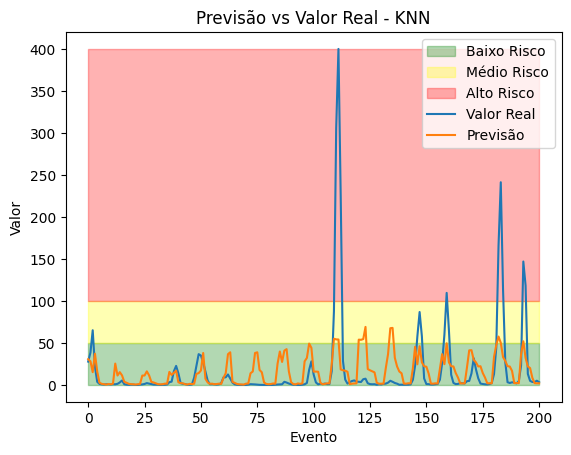

Treinando Decision Tree...
Melhores parâmetros encontrados:
{'max_depth': 3}
Coeficiente de Determinação (R2): 0.02929076319944557


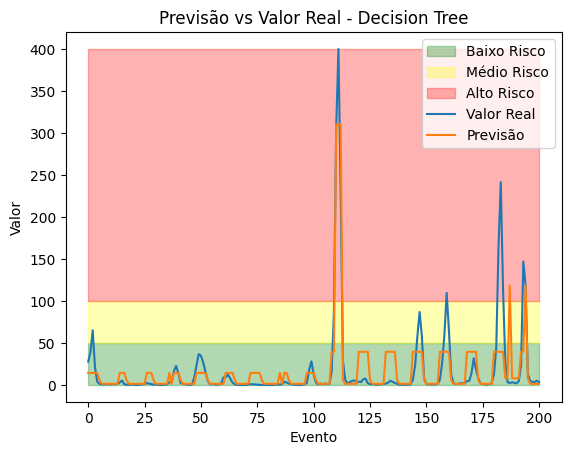

Treinando SVM...
Melhores parâmetros encontrados:
{'C': 14.0, 'epsilon': 0.1}
Coeficiente de Determinação (R2): 0.19821073590086868


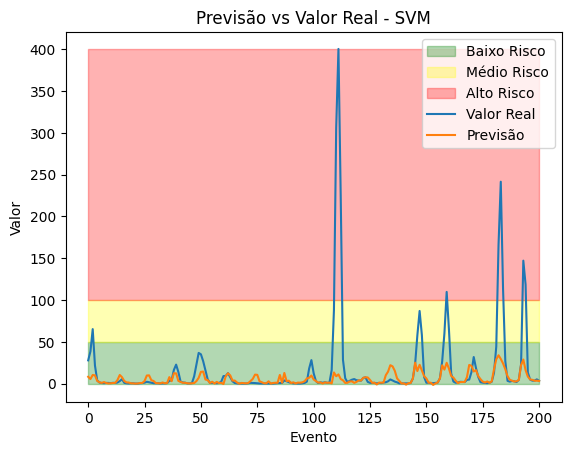

Treinando Random Forest...
Melhores parâmetros encontrados:
{'max_depth': 45, 'n_estimators': 10}
Coeficiente de Determinação (R2): 0.6234681991762829


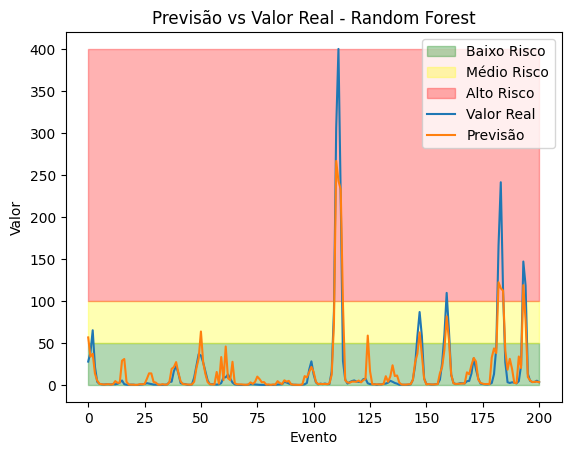

Treinando Gradient Boosting...
Melhores parâmetros encontrados:
{'learning_rate': 0.01, 'n_estimators': 100}
Coeficiente de Determinação (R2): 0.3176116090791422


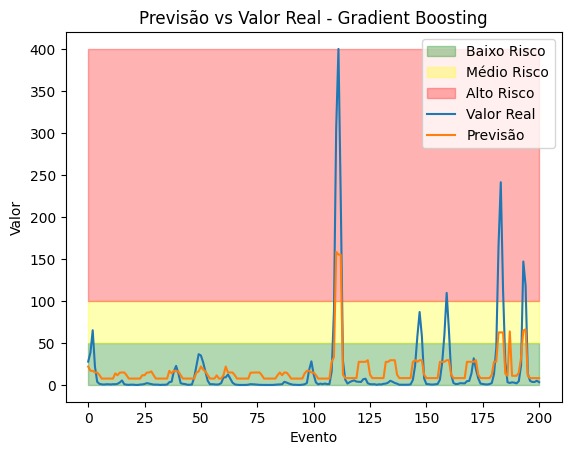

In [17]:
for name, model in models.items():
    print(f"Treinando {name}...")
    grid_search = GridSearchCV(model, params[name], cv=5, scoring="r2")
    grid_search.fit(X_train, y_train)
    print("Melhores parâmetros encontrados:")
    print(grid_search.best_params_)
    best_model = grid_search.best_estimator_

    predictions = best_model.predict(X_test)
    r2 = r2_score(y_test, predictions)
    print("Coeficiente de Determinação (R2):", r2)

    predictions = best_model.predict(X)
    
    plt.figure()
    plt.fill_between(range(len(y)), 0, baixo_limite, color='green', alpha=0.3, label='Baixo Risco')
    plt.fill_between(range(len(y)), baixo_limite, medio_limite, color='yellow', alpha=0.3, label='Médio Risco')
    plt.fill_between(range(len(y)), medio_limite, max(max(y), max(predictions)), color='red', alpha=0.3, label='Alto Risco')
    plt.plot(range(len(y)), y, label='Valor Real')
    plt.plot(range(len(predictions)), predictions, label='Previsão')
    plt.xlabel('Evento')
    plt.ylabel('Valor')
    plt.title(f'Previsão vs Valor Real - {name}')
    plt.legend()
    plt.show()


O melhor modelo obtido foi:

* Random Forest com {'max_depth': 45, 'n_estimators': 10}, resultando em um Coeficiente de Determinação (R²): 0.6234681991762829

Os casos de dengue podem ser altamente heterogêneos devido a uma variedade de fatores, como diferenças geográficas, políticas de saúde pública e comportamento humano. Fazer a modelagem dessa regressão é bem complicado, já que teria que envolver comportamentos difíceis de mensurar, como o comportamento humano, porém com esse trabalho foi possível aprender que tirar insights dos dados, procurar melhorar a base de dados para cada vez melhorar seus resultados. Conforme comentado nos itens anteriores, começamos com um R² de 0.14 usando o dataset original, evoluímos para 0.50 com a adição de mais medidas como população e investimento em saúde, ao fazer mais pré-processamento chegamos num R² de 0.62. Ficaria de trabalhos futuros estudar e trazer mais insights para melhorar esse modelo de regressão.

# <a id="classificacao"></a> 10. Treinamento de Modelos de Classificação

A fim de explorar mais conhecimentos apresentados em aula, este capítulo propõe utilizar a mesma base de dados para realizar uma classificação do nível de risco. Será criada uma nova medida categórica que receberá o nível de risco.

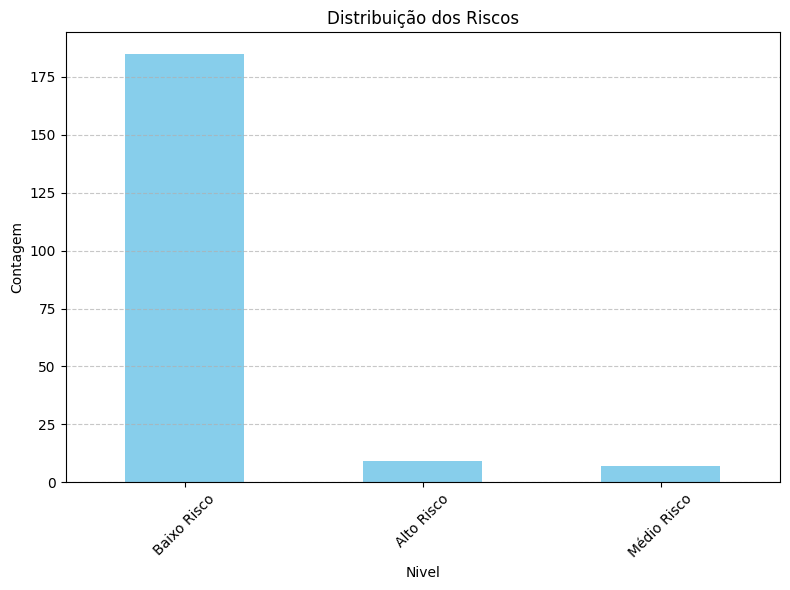

In [18]:
def atribuir_risco(valor):
    if valor <= baixo_limite:
        return "Baixo Risco"
    elif valor <= medio_limite:
        return "Médio Risco"
    else:
        return "Alto Risco"
X = df.copy()
del X["casos_p_100k"]
y = df["casos_p_100k"].apply(atribuir_risco)
counts = y.value_counts()
plt.figure(figsize=(8, 6))
counts.plot(kind='bar', color='skyblue')
plt.title('Distribuição dos Riscos')
plt.xlabel('Nivel')
plt.ylabel('Contagem')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Temos um grande desequilíbrio nos dados, com um número muito maior de observações de baixo risco do que das outras categorias. Em casos mais avançados, seria importante trazer mais observações das outras categorias para tentar equilibrar os dados. No entanto, mesmo sem esse procedimento, já foi possível obter resultados significativos em nosso caso.

Os modelos serão executados novamente, mas desta vez como classificadores.

In [19]:

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "SVM": SVC(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
}

params = {
    "KNN": {"n_neighbors": list(range(16,31))},
    "Decision Tree": {"max_depth": list(range(1, 31))},
    "SVM": {"C": [0.1, 1, 10], "gamma": [0.1, 1, 10]},
    "Random Forest": {"n_estimators": [10, 50, 100], "max_depth": [None, 10, 50, 100]},
    "Gradient Boosting": {"n_estimators": [50, 100, 150], "learning_rate": [0.01, 0.1, 0.5]},
}

for name, model in models.items():
    print(f"Treinando {name}...")
    grid_search = GridSearchCV(model, params[name], cv=5, scoring="accuracy")
    grid_search.fit(X_train, y_train)
    print("Melhores parâmetros encontrados:")
    print(grid_search.best_params_)
    best_model = grid_search.best_estimator_

    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Acurácia:", accuracy)
    print("Relatório de Classificação:")
    print(classification_report(y_test, y_pred, zero_division=1))
    print("Matriz de Confusão:")
    print(confusion_matrix(y_test, y_pred))
    print("\n")


Treinando KNN...
Melhores parâmetros encontrados:
{'n_neighbors': 16}
Acurácia: 0.926829268292683
Relatório de Classificação:
              precision    recall  f1-score   support

  Alto Risco       1.00      0.00      0.00         1
 Baixo Risco       0.93      1.00      0.96        38
 Médio Risco       1.00      0.00      0.00         2

    accuracy                           0.93        41
   macro avg       0.98      0.33      0.32        41
weighted avg       0.93      0.93      0.89        41

Matriz de Confusão:
[[ 0  1  0]
 [ 0 38  0]
 [ 0  2  0]]


Treinando Decision Tree...
Melhores parâmetros encontrados:
{'max_depth': 5}
Acurácia: 0.9512195121951219
Relatório de Classificação:
              precision    recall  f1-score   support

  Alto Risco       1.00      1.00      1.00         1
 Baixo Risco       0.95      1.00      0.97        38
 Médio Risco       1.00      0.00      0.00         2

    accuracy                           0.95        41
   macro avg       0.98     

Desta vez, ao contrário da regressão, todos os modelos apresentaram bons resultados, com uma acurácia superior a 90%, aparentemente essa tarefa foi mais simples do que a regressão.